In [1]:
from typing import Dict, Union, Tuple
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score, cross_validate
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from xgboost import XGBRegressor

from src.data.dataLoader import StructuralBreakDataLoader, TimeSeriesData
from src.data.data_utility import get_sliding_windows_from_sequence
from src.utils.training_class import TimeSeriesModelTrainer

In [2]:
# Load the data
print("Loading data...")
data_loader = StructuralBreakDataLoader()
X_train, y_train, X_test = data_loader.load_data(use_crunch=False)

# Get all time series
train_series = data_loader.get_all_train_series()
test_series = data_loader.get_all_test_series()

print(f"Loaded {len(train_series)} training series and {len(test_series)} test series")
print(f"Class distribution - Positive: {sum(ts.has_break for ts in train_series.values())}, "
      f"Negative: {sum(not ts.has_break for ts in train_series.values())}")

Loading data...


INFO:src.data.dataLoader:Data loaded successfully from local files


Loaded 10001 training series and 101 test series
Class distribution - Positive: 2909, Negative: 7092


In [20]:
# Lists to store CV results
mean_test_scores = []
mean_train_scores = []
std_test_scores = []
std_train_scores = []

# Process all series
for key in tqdm(train_series.keys()):
    windows = np.lib.stride_tricks.sliding_window_view(train_series[key].period_0_values, window_shape=6)
    
    x = windows[:, :5]
    y = windows[:, 5]
    N = windows.shape[0]
    split_idx = int(N*0.8)
    
    # Fixed train/test split (though not used in CV)
    x_train, x_test = x[:split_idx], x[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    model = LinearRegression()
    
    # Perform cross-validation and collect results
    cv_results = cross_validate(model, x, y, cv=5, 
                               scoring='r2',  # You can change this metric
                               return_train_score=True)
    
    # Store mean scores for this key
    mean_test_scores.append(cv_results['test_score'].mean())
    mean_train_scores.append(cv_results['train_score'].mean())
    std_test_scores.append(cv_results['test_score'].std())
    std_train_scores.append(cv_results['train_score'].std())

100%|██████████| 10001/10001 [01:30<00:00, 110.65it/s]


In [281]:
windows = np.lib.stride_tricks.sliding_window_view(train_series[0].period_0_values, window_shape=6)

dt = windows[:, -1]

percentages = np.arange(5, 100, 45)
percentages = np.array([50])
percentiles = np.percentile(dt, percentages)
y = np.digitize(dt, percentiles)

x = windows[:, :-1]

model = LogisticRegression()

# Perform cross-validation and collect results
cv_results = cross_validate(model, x, y, cv=5,
                            scoring='roc_auc_ovo',
                           return_train_score=True)
cv_results["test_score"].mean(), cv_results["test_score"].std()

(np.float64(0.6024403087443441), np.float64(0.018637813005279596))

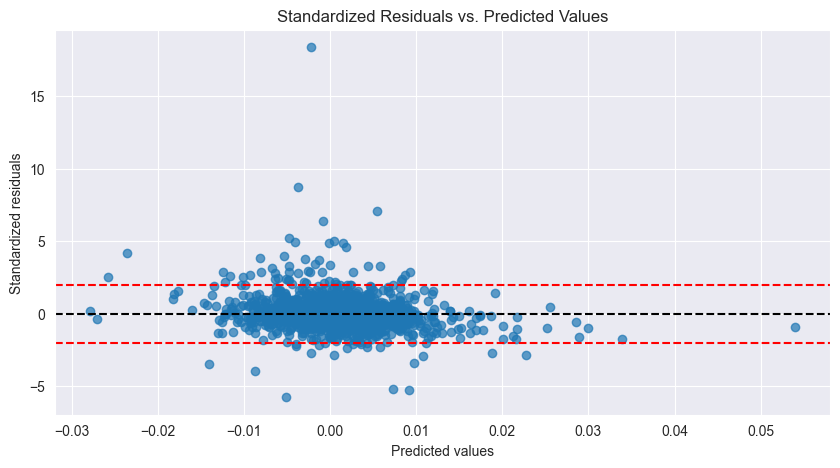

In [300]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler

# Create sliding windows from the time series
windows = np.lib.stride_tricks.sliding_window_view(train_series[777].period_0_values, window_shape=20)

# Features: first 5 values; Target: last value in window
x = windows[:, :-1]
y = windows[:, -1]

# Standardize features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Fit linear regression model with cross-validated predictions
model = LinearRegression()
y_pred = cross_val_predict(model, x_scaled, y, cv=5)

# Compute residuals and standardized residuals
residuals = y - y_pred
std_residuals = residuals / np.std(residuals)

# Plot standardized residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_pred, std_residuals, alpha=0.7)
plt.axhline(0, color='black', linestyle='--')
plt.axhline(2, color='red', linestyle='--')
plt.axhline(-2, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Standardized residuals")
plt.title("Standardized Residuals vs. Predicted Values")
plt.grid(True)
plt.show()


In [267]:
percentages

array([ 5, 50, 95])

In [232]:
cv_results["train_score"].mean(), cv_results["train_score"].std()

(np.float64(0.06589216593195901), np.float64(0.011664988679559568))

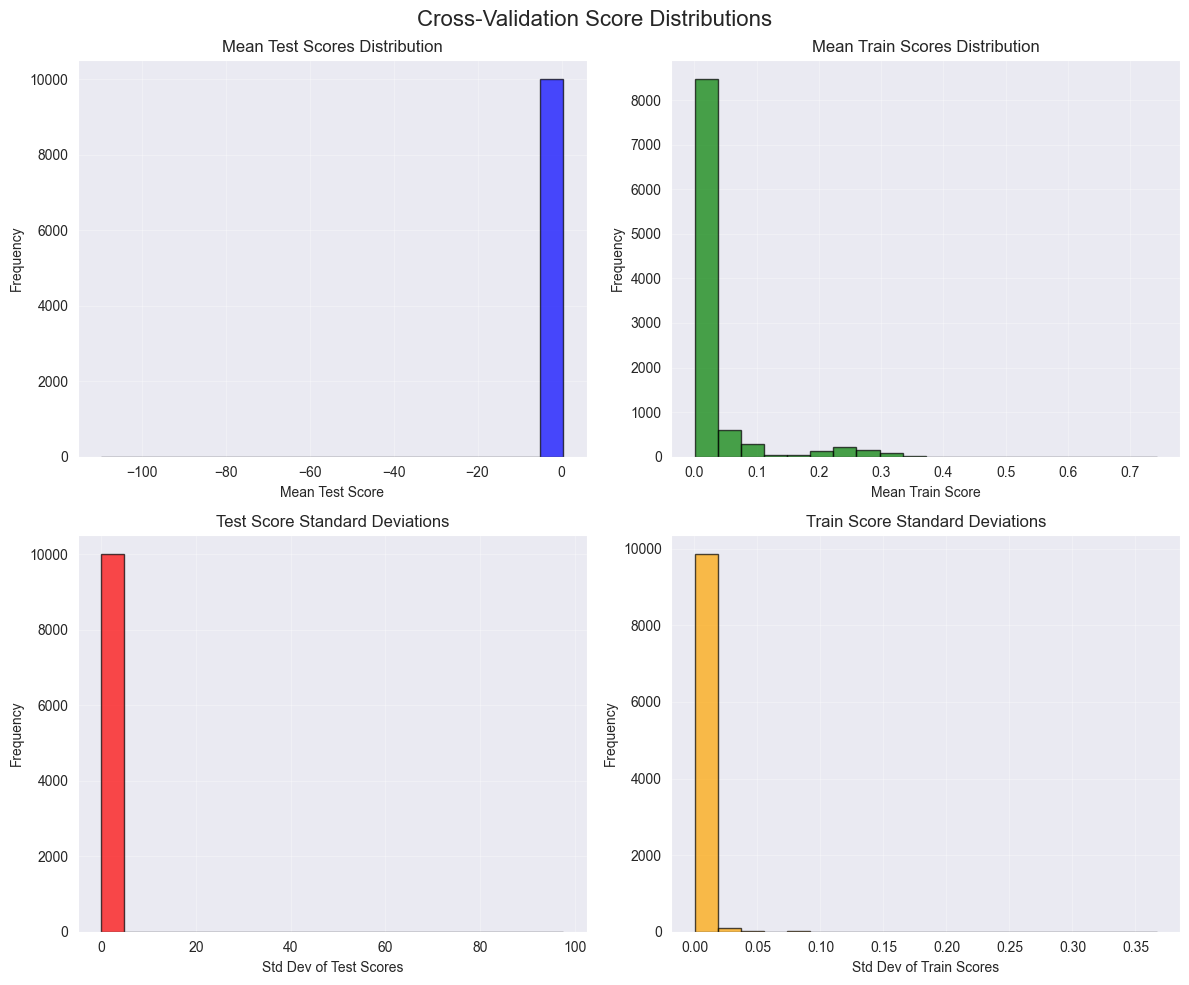

Summary Statistics:
Test Scores - Mean: -0.0023, Std: 1.1065
Train Scores - Mean: 0.0290, Std: 0.0610
Number of series processed: 10001


In [21]:
# Convert to numpy arrays for easier manipulation
mean_test_scores = np.array(mean_test_scores)
mean_train_scores = np.array(mean_train_scores)
std_test_scores = np.array(std_test_scores)
std_train_scores = np.array(std_train_scores)

# Create histograms
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Cross-Validation Score Distributions', fontsize=16)

# Test scores histogram
axes[0, 0].hist(mean_test_scores, bins=20, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].set_title('Mean Test Scores Distribution')
axes[0, 0].set_xlabel('Mean Test Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# Train scores histogram
axes[0, 1].hist(mean_train_scores, bins=20, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].set_title('Mean Train Scores Distribution')
axes[0, 1].set_xlabel('Mean Train Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# Test score standard deviations
axes[1, 0].hist(std_test_scores, bins=20, alpha=0.7, color='red', edgecolor='black')
axes[1, 0].set_title('Test Score Standard Deviations')
axes[1, 0].set_xlabel('Std Dev of Test Scores')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

# Train score standard deviations
axes[1, 1].hist(std_train_scores, bins=20, alpha=0.7, color='orange', edgecolor='black')
axes[1, 1].set_title('Train Score Standard Deviations')
axes[1, 1].set_xlabel('Std Dev of Train Scores')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary Statistics:")
print(f"Test Scores - Mean: {mean_test_scores.mean():.4f}, Std: {mean_test_scores.std():.4f}")
print(f"Train Scores - Mean: {mean_train_scores.mean():.4f}, Std: {mean_train_scores.std():.4f}")
print(f"Number of series processed: {len(mean_test_scores)}")

# Optional: Save the results
results_dict = {
    'mean_test_scores': mean_test_scores,
    'mean_train_scores': mean_train_scores,
    'std_test_scores': std_test_scores,
    'std_train_scores': std_train_scores
}

# You can access individual results like this:
# print(f"Best performing series (test): {mean_test_scores.max():.4f}")
# print(f"Worst performing series (test): {mean_test_scores.min():.4f}")

In [25]:
mean_test_scores

array([ 0.07320324, -0.00154285, -0.00051065, ...,  0.07428846,
        0.00120625,  0.01425045], shape=(10001,))

In [19]:
cv_results

{'fit_time': array([0.01190996, 0.00099897, 0.        , 0.        , 0.        ]),
 'score_time': array([0.00099993, 0.        , 0.        , 0.        , 0.00098491]),
 'test_score': array([0.06673385, 0.07379653, 0.10166689, 0.05083421, 0.07298473])}

In [12]:
train_series[0].period_0_values

array([-0.00556448,  0.00370513,  0.01316445, ...,  0.0027958 ,
        0.00965648,  0.00668773], shape=(1351,))

In [15]:
np.lib.stride_tricks.sliding_window_view(train_series[0].period_0_values, window_shape=5)

array([[-0.00556448,  0.00370513,  0.01316445,  0.00715094, -0.00997896],
       [ 0.00370513,  0.01316445,  0.00715094, -0.00997896, -0.00908046],
       [ 0.01316445,  0.00715094, -0.00997896, -0.00908046, -0.00560141],
       ...,
       [-0.00649694, -0.00580233,  0.00370533,  0.00667221,  0.0027958 ],
       [-0.00580233,  0.00370533,  0.00667221,  0.0027958 ,  0.00965648],
       [ 0.00370533,  0.00667221,  0.0027958 ,  0.00965648,  0.00668773]],
      shape=(1347, 5))

100%|██████████| 10001/10001 [00:10<00:00, 942.75it/s]


Normality Test Results:
Total series tested: 10001
Series with normal residuals (p > 0.05): 1664 (16.6%)
Series with non-normal residuals: 8337 (83.4%)


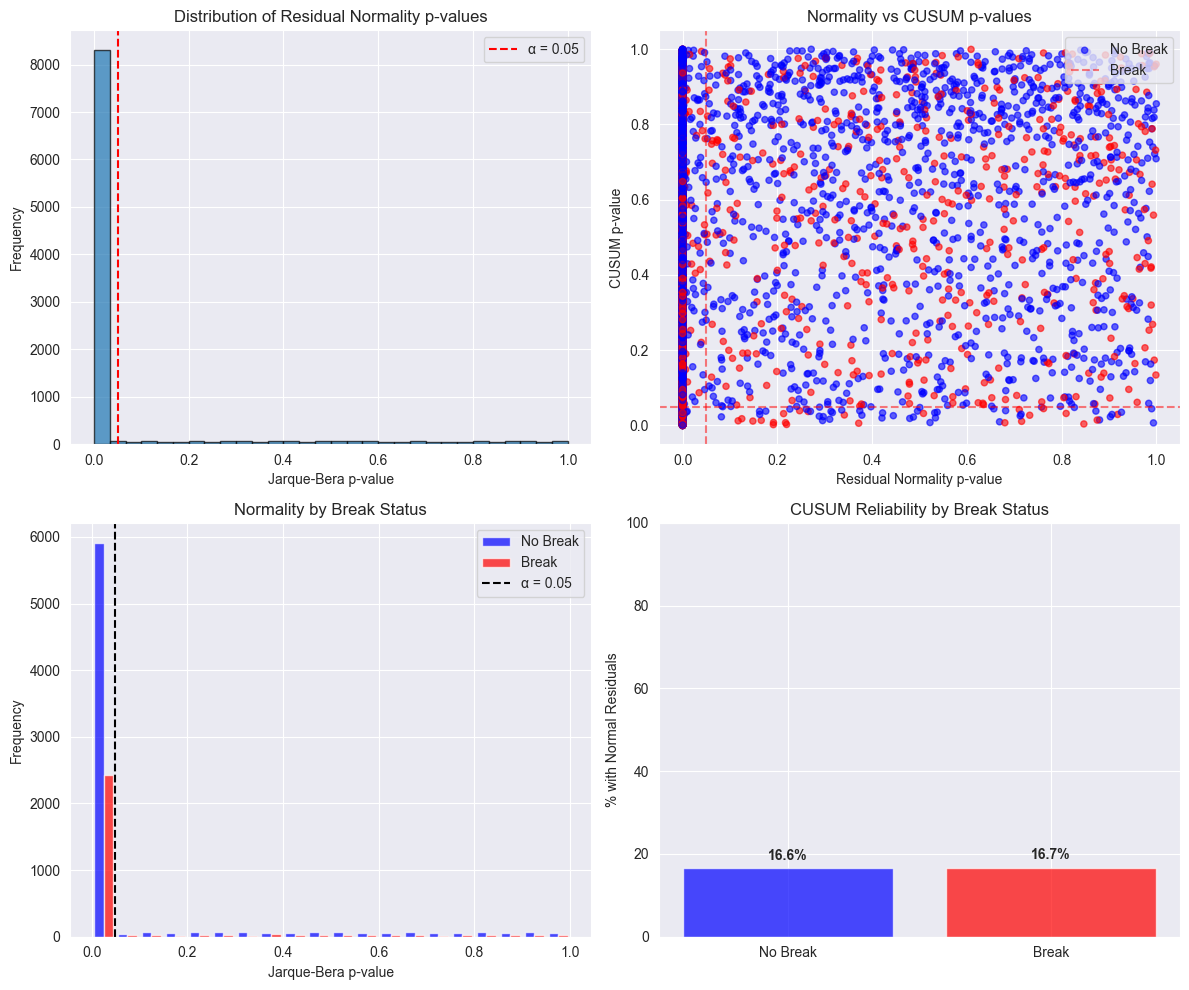


CUSUM Reliability Assessment:
Series with breaks - normal residuals: 16.7%
Series without breaks - normal residuals: 16.6%
✗ Low normality rate - CUSUM results may be unreliable


In [5]:
from src.features.extract_cusum_breakpoint_features import CusumBreakpointFeatureExtractor
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm

# Test normality of CUSUM residuals
normality_results = []
cusum_pvalues = []
has_breaks = []
cusumBreakpointExtractor = CusumBreakpointFeatureExtractor(30, no_cache=True)

for series_id, ts_obj in tqdm(list(train_series.items())):  # Test first 200 series
    try:
        # Get residuals from CUSUM regression
        series_pre, series_post = cusumBreakpointExtractor._extract_period_values(ts_obj)
        series_full = np.concatenate([series_pre, series_post])
        X_full, y_full = cusumBreakpointExtractor._build_lagged_matrix(series_full)
        
        if X_full is not None and len(y_full) > 20:  # Need enough data
            beta_full, residuals, _ = cusumBreakpointExtractor._ols_fit(X_full, y_full)
            
            # Test normality using Jarque-Bera
            jb_stat, jb_pval = stats.jarque_bera(residuals)
            
            # Get CUSUM p-value for comparison
            cusum_features = cusumBreakpointExtractor.extract_features(ts_obj)
            cusum_pval = cusum_features.get('cusum_pvalue', np.nan)
            
            normality_results.append(jb_pval)
            cusum_pvalues.append(cusum_pval)
            has_breaks.append(ts_obj.has_break)
            
    except Exception as e:
        continue

# Convert to numpy arrays
normality_results = np.array(normality_results)
cusum_pvalues = np.array(cusum_pvalues)
has_breaks = np.array(has_breaks)

# Remove NaN values
valid_mask = ~(np.isnan(normality_results) | np.isnan(cusum_pvalues))
normality_results = normality_results[valid_mask]
cusum_pvalues = cusum_pvalues[valid_mask]
has_breaks = has_breaks[valid_mask]

# Summary statistics
normal_residuals = (normality_results > 0.05).sum()
total_series = len(normality_results)

print(f"Normality Test Results:")
print(f"Total series tested: {total_series}")
print(f"Series with normal residuals (p > 0.05): {normal_residuals} ({normal_residuals/total_series*100:.1f}%)")
print(f"Series with non-normal residuals: {total_series - normal_residuals} ({(total_series-normal_residuals)/total_series*100:.1f}%)")

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Distribution of normality p-values
axes[0,0].hist(normality_results, bins=30, alpha=0.7, edgecolor='black')
axes[0,0].axvline(x=0.05, color='red', linestyle='--', label='α = 0.05')
axes[0,0].set_xlabel('Jarque-Bera p-value')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of Residual Normality p-values')
axes[0,0].legend()

# 2. Normality vs CUSUM p-values
colors = ['red' if break_val else 'blue' for break_val in has_breaks]
axes[0,1].scatter(normality_results, cusum_pvalues, c=colors, alpha=0.6, s=20)
axes[0,1].axvline(x=0.05, color='red', linestyle='--', alpha=0.5)
axes[0,1].axhline(y=0.05, color='red', linestyle='--', alpha=0.5)
axes[0,1].set_xlabel('Residual Normality p-value')
axes[0,1].set_ylabel('CUSUM p-value')
axes[0,1].set_title('Normality vs CUSUM p-values')
axes[0,1].legend(['No Break', 'Break'], loc='upper right')

# 3. Normality by break status
break_normal = normality_results[has_breaks == True]
no_break_normal = normality_results[has_breaks == False]

axes[1,0].hist([no_break_normal, break_normal], bins=20, alpha=0.7, 
               label=['No Break', 'Break'], color=['blue', 'red'])
axes[1,0].axvline(x=0.05, color='black', linestyle='--', label='α = 0.05')
axes[1,0].set_xlabel('Jarque-Bera p-value')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Normality by Break Status')
axes[1,0].legend()

# 4. CUSUM reliability assessment
reliable_cusum = (normality_results > 0.05)
reliable_rate_break = reliable_cusum[has_breaks == True].mean() * 100
reliable_rate_no_break = reliable_cusum[has_breaks == False].mean() * 100

categories = ['No Break', 'Break']
rates = [reliable_rate_no_break, reliable_rate_break]
axes[1,1].bar(categories, rates, color=['blue', 'red'], alpha=0.7)
axes[1,1].set_ylabel('% with Normal Residuals')
axes[1,1].set_title('CUSUM Reliability by Break Status')
axes[1,1].set_ylim(0, 100)

for i, rate in enumerate(rates):
    axes[1,1].text(i, rate + 2, f'{rate:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nCUSUM Reliability Assessment:")
print(f"Series with breaks - normal residuals: {reliable_rate_break:.1f}%")
print(f"Series without breaks - normal residuals: {reliable_rate_no_break:.1f}%")

if normal_residuals / total_series > 0.8:
    print("✓ High normality rate - CUSUM features should be reliable")
elif normal_residuals / total_series > 0.6:
    print("⚠ Moderate normality rate - consider adding normality check as feature")
else:
    print("✗ Low normality rate - CUSUM results may be unreliable")

In [7]:
# Quick diagnostic of residual characteristics
print(f"\nResidual Characteristics:")
print(f"Mean JB p-value: {np.mean(normality_results):.4f}")
print(f"Median JB p-value: {np.median(normality_results):.4f}")

# Check for extreme skewness/kurtosis
skewness_vals = []
kurtosis_vals = []

for series_id, ts_obj in list(train_series.items())[:50]:
    try:
        series_pre, series_post = cusumBreakpointExtractor._extract_period_values(ts_obj)
        series_full = np.concatenate([series_pre, series_post])
        X_full, y_full = cusumBreakpointExtractor._build_lagged_matrix(series_full)
        
        if X_full is not None:
            beta_full, residuals, _ = cusumBreakpointExtractor._ols_fit(X_full, y_full)
            skewness_vals.append(stats.skew(residuals))
            kurtosis_vals.append(stats.kurtosis(residuals))
    except:
        continue

print(f"Mean residual skewness: {np.mean(skewness_vals):.3f}")
print(f"Mean residual kurtosis: {np.mean(kurtosis_vals):.3f}")
print(f"Normal kurtosis is 0, excess kurtosis > 3 indicates heavy tails")


Residual Characteristics:
Mean JB p-value: 0.0882
Median JB p-value: 0.0000
Mean residual skewness: 0.213
Mean residual kurtosis: 11.612
Normal kurtosis is 0, excess kurtosis > 3 indicates heavy tails


<Axes: ylabel='Count'>

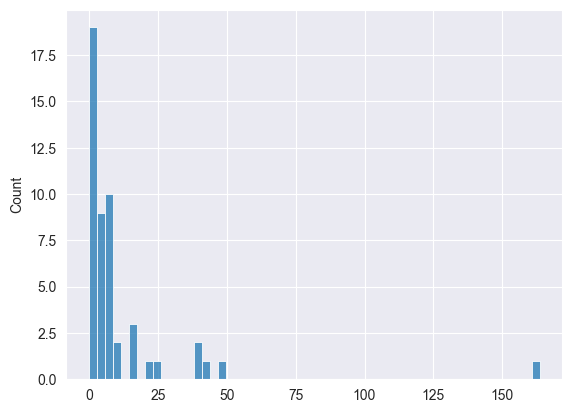

In [11]:
sns.histplot(kurtosis_vals, stat='count')

In [15]:
import numpy as np
from scipy import stats
import pandas as pd
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt

# ============================================================================
# APPROACH 1: DATA TRANSFORMATIONS
# ============================================================================

def test_transformations(series_full, cusumExtractor):
    """Test different data transformations for better normality."""
    
    transformations = {}
    
    # 1. Log transformation (for positive data)
    if np.all(series_full > 0):
        log_series = np.log(series_full)
        transformations['log'] = log_series
    
    # 2. Log differences (returns)
    if np.all(series_full > 0):
        log_returns = np.diff(np.log(series_full))
        # Pad with first value to maintain length
        log_returns = np.concatenate([[log_returns[0]], log_returns])
        transformations['log_returns'] = log_returns
    
    # 3. Winsorize outliers (clip extreme values)
    p1, p99 = np.percentile(series_full, [1, 99])
    winsorized = np.clip(series_full, p1, p99)
    transformations['winsorized'] = winsorized
    
    # 4. Box-Cox transformation
    try:
        if np.all(series_full > 0):
            boxcox_series, lmbda = stats.boxcox(series_full)
            transformations['boxcox'] = boxcox_series
    except:
        pass
    
    # 5. Yeo-Johnson (works with negative values)
    try:
        pt = PowerTransformer(method='yeo-johnson', standardize=False)
        yj_series = pt.fit_transform(series_full.reshape(-1, 1)).flatten()
        transformations['yeo_johnson'] = yj_series
    except:
        pass
    
    # 6. Simple differences
    diff_series = np.diff(series_full)
    diff_series = np.concatenate([[diff_series[0]], diff_series])
    transformations['differences'] = diff_series
    
    # Test each transformation
    results = {}
    for name, transformed_series in transformations.items():
        try:
            X, y = cusumExtractor._build_lagged_matrix(transformed_series)
            if X is not None and len(y) > 20:
                beta, residuals, _ = cusumExtractor._ols_fit(X, y)
                jb_stat, jb_pval = stats.jarque_bera(residuals)
                kurtosis = stats.kurtosis(residuals)
                
                results[name] = {
                    'jb_pvalue': jb_pval,
                    'kurtosis': kurtosis,
                    'skewness': stats.skew(residuals),
                    'normal': jb_pval > 0.05
                }
        except:
            continue
    
    return results

# ============================================================================
# APPROACH 2: NONLINEAR AUTOREGRESSIVE MODELS
# ============================================================================

def nonlinear_ar_residuals(series, lags=3):
    """Fit nonlinear AR model and return residuals."""
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.preprocessing import PolynomialFeatures
    
    n = len(series)
    if n <= lags + 10:
        return None
    
    # Create lagged features
    X = np.zeros((n - lags, lags))
    for i in range(lags):
        X[:, i] = series[lags-1-i:n-1-i]
    
    y = series[lags:]
    
    # Method 1: Polynomial features (degree 2)
    try:
        poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
        X_poly = poly.fit_transform(X)
        
        # Fit with regularization to avoid overfitting
        from sklearn.linear_model import Ridge
        model = Ridge(alpha=0.1)
        model.fit(X_poly, y)
        
        residuals = y - model.predict(X_poly)
        return residuals, 'polynomial'
    except:
        pass
    
    # Method 2: Random Forest (if polynomial fails)
    try:
        rf = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42)
        rf.fit(X, y)
        residuals = y - rf.predict(X)
        return residuals, 'random_forest'
    except:
        pass
    
    return None, None

# ============================================================================
# APPROACH 3: ROBUST REGRESSION
# ============================================================================

def robust_ar_residuals(series, lags=3):
    """Fit robust AR model using Huber regression."""
    from sklearn.linear_model import HuberRegressor
    
    n = len(series)
    if n <= lags + 10:
        return None
    
    # Create lagged design matrix
    X = np.ones((n - lags, lags + 1))
    for i in range(lags):
        X[:, i+1] = series[lags-1-i:n-1-i]
    
    y = series[lags:]
    
    try:
        # Huber regression is robust to outliers
        huber = HuberRegressor(epsilon=1.35, alpha=0.01)
        huber.fit(X, y)
        residuals = y - huber.predict(X)
        return residuals
    except:
        return None

# ============================================================================
# COMPREHENSIVE TESTING FUNCTION
# ============================================================================

def test_all_improvements(data_handler, cusumExtractor, sample_size=100):
    """Test all improvement methods on your data."""
    
    train_data_dict = data_handler.get_all_train_series()
    sample_series = dict(list(train_data_dict.items())[:sample_size])
    
    results = {
        'original': [],
        'best_transform': [],
        'nonlinear': [],
        'robust': []
    }
    
    transformation_counts = {}
    
    print(f"Testing improvements on {len(sample_series)} series...")
    
    for series_id, ts_obj in sample_series.items():
        try:
            # Get original series
            series_pre, series_post = cusumExtractor._extract_period_values(ts_obj)
            series_full = np.concatenate([series_pre, series_post])
            
            if len(series_full) < 30:
                continue
            
            # 1. Original method
            X_orig, y_orig = cusumExtractor._build_lagged_matrix(series_full)
            if X_orig is not None:
                _, residuals_orig, _ = cusumExtractor._ols_fit(X_orig, y_orig)
                jb_orig = stats.jarque_bera(residuals_orig)[1]
                results['original'].append(jb_orig > 0.05)
            
            # 2. Best transformation
            transform_results = test_transformations(series_full, cusumExtractor)
            if transform_results:
                best_transform = max(transform_results.items(), 
                                   key=lambda x: x[1]['jb_pvalue'])
                results['best_transform'].append(best_transform[1]['normal'])
                
                # Count which transformations work best
                if best_transform[1]['normal']:
                    transformation_counts[best_transform[0]] = \
                        transformation_counts.get(best_transform[0], 0) + 1
            
            # 3. Nonlinear model
            nl_result = nonlinear_ar_residuals(series_full, lags=cusumExtractor.lags)
            if nl_result[0] is not None:
                jb_nl = stats.jarque_bera(nl_result[0])[1]
                results['nonlinear'].append(jb_nl > 0.05)
            
            # 4. Robust regression
            robust_residuals = robust_ar_residuals(series_full, lags=cusumExtractor.lags)
            if robust_residuals is not None:
                jb_robust = stats.jarque_bera(robust_residuals)[1]
                results['robust'].append(jb_robust > 0.05)
        
        except Exception as e:
            continue
    
    # Calculate improvement rates
    improvements = {}
    for method, outcomes in results.items():
        if outcomes:
            improvements[method] = np.mean(outcomes) * 100
    
    print("\n" + "="*60)
    print("NORMALITY IMPROVEMENT RESULTS")
    print("="*60)
    
    for method, rate in improvements.items():
        print(f"{method.replace('_', ' ').title()}: {rate:.1f}% normal residuals")
    
    if 'original' in improvements:
        baseline = improvements['original']
        print(f"\nIMPROVEMENTS OVER BASELINE ({baseline:.1f}%):")
        for method, rate in improvements.items():
            if method != 'original':
                improvement = rate - baseline
                print(f"  {method.replace('_', ' ').title()}: {improvement:+.1f} percentage points")
    
    print(f"\nBEST TRANSFORMATIONS:")
    for transform, count in sorted(transformation_counts.items(), 
                                 key=lambda x: x[1], reverse=True):
        print(f"  {transform}: {count} series improved")
    
    return improvements, transformation_counts

# ============================================================================
# USAGE EXAMPLE
# ============================================================================

# Run comprehensive test
print("Testing all improvement approaches...")
improvements, best_transforms = test_all_improvements(
    data_loader, cusumBreakpointExtractor, sample_size=100
)

Testing all improvement approaches...
Testing improvements on 100 series...


C:\Users\StefanConstantin\Documents\Git\Python\ADIA Lab Structural Break Challenge\.venv\Lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\StefanConstantin\Documents\Git\Python\ADIA Lab Structural Break Challenge\.venv\Lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\StefanConstantin\Documents\Git\Python\ADIA Lab Structural Break Challenge\.


NORMALITY IMPROVEMENT RESULTS
Original: 19.0% normal residuals
Best Transform: 20.0% normal residuals
Nonlinear: 19.0% normal residuals
Robust: 18.0% normal residuals

IMPROVEMENTS OVER BASELINE (19.0%):
  Best Transform: +1.0 percentage points
  Nonlinear: +0.0 percentage points
  Robust: -1.0 percentage points

BEST TRANSFORMATIONS:
  yeo_johnson: 14 series improved
  differences: 4 series improved
  winsorized: 2 series improved
